Fall 2024
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

DSAI 305,
Interpretability & Explainability in AI

University of Science and Technology, Zewail City

 **Salma Wael 202201761**

<br>

<h1 align="center"></h3>
<h1 align="center">Phase 3</h3>
<h1 align="center">XGBoost (eXtreme Gradient Boosting) classifier that uses VGG16 features</h3>

---

# 1- Preprocessing - EDA
---------------------------------------------

# 1. Reading Data

In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!mv "/content/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [ ]:
data_dir = "/content/oasis_dataset/Data"

In [ ]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f" Directory: {root}")
        print(f" Files: {files[:5]}")  # Display first 5 files for each directory
        print()

 Directory: /content/oasis_dataset/Data/Moderate Dementia
 Files: ['OAS1_0351_MR1_mpr-4_113.jpg', 'OAS1_0351_MR1_mpr-2_119.jpg', 'OAS1_0308_MR1_mpr-1_128.jpg', 'OAS1_0351_MR1_mpr-4_110.jpg', 'OAS1_0351_MR1_mpr-4_133.jpg']

 Directory: /content/oasis_dataset/Data/Mild Dementia
 Files: ['OAS1_0122_MR1_mpr-4_108.jpg', 'OAS1_0052_MR1_mpr-3_140.jpg', 'OAS1_0382_MR1_mpr-3_131.jpg', 'OAS1_0278_MR1_mpr-4_121.jpg', 'OAS1_0031_MR1_mpr-4_147.jpg']

 Directory: /content/oasis_dataset/Data/Non Demented
 Files: ['OAS1_0061_MR1_mpr-1_142.jpg', 'OAS1_0265_MR1_mpr-1_152.jpg', 'OAS1_0266_MR1_mpr-2_125.jpg', 'OAS1_0109_MR1_mpr-3_110.jpg', 'OAS1_0114_MR1_mpr-4_100.jpg']

 Directory: /content/oasis_dataset/Data/Very mild Dementia
 Files: ['OAS1_0161_MR1_mpr-1_144.jpg', 'OAS1_0060_MR1_mpr-4_144.jpg', 'OAS1_0352_MR1_mpr-3_144.jpg', 'OAS1_0315_MR1_mpr-2_135.jpg', 'OAS1_0084_MR1_mpr-3_136.jpg']



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128  # Adjust image size if needed
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill pixels after transformations
)

# Training data generator
train_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


## 2- EDA and Preprocessing

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import Counter
from tqdm import tqdm

In [ ]:
#Classes
class_names = os.listdir(data_dir)
print("Classes found:", class_names)

Classes found: ['Moderate Dementia', 'Mild Dementia', 'Non Demented', 'Very mild Dementia']


In [ ]:
# Number of images per each class
from PIL import Image
import os
import numpy as np

image_shapes = []
total_images = 0

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    total_images += len(images)

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            image_shapes.append(np.array(img).shape)
        except:
            continue

    print(f"{cls}: {len(images)} images")
# Convert to array for easy stats
image_shapes = np.array(image_shapes)

print(f"Total Images: {total_images}")

Moderate Dementia: 488 images
Mild Dementia: 5002 images
Non Demented: 67222 images
Very mild Dementia: 13725 images
Total Images: 86437


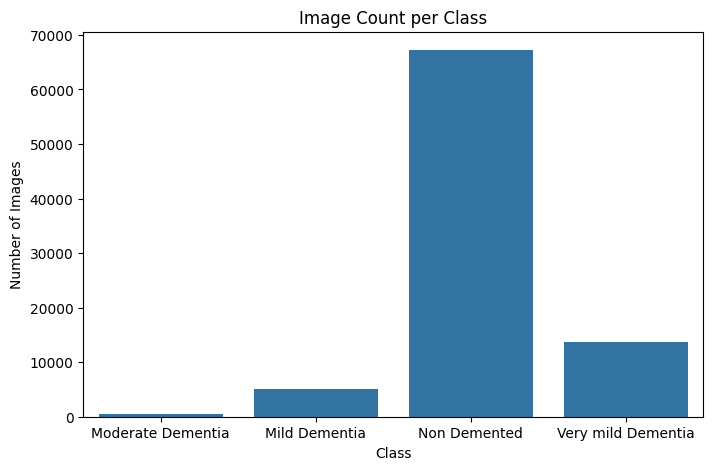

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
#Train Test Split
import shutil

train_dir=os.path.join(data_dir, 'train')
test_dir=os.path.join(data_dir, 'test')

for cls in class_names:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def split_and_copy(source_path, class_name, train_dest, test_dest, test_ratio=0.2):
    all_files = os.listdir(source_path)
    np.random.shuffle(all_files)

    train_files, test_files = np.split(np.array(all_files), [int(len(all_files) * (1 - test_ratio))])

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

for cls in class_names:
    split_and_copy(os.path.join(data_dir, cls), cls, train_dir, test_dir)

print("Train-test split completed!")

Train-test split completed!


In [ ]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.


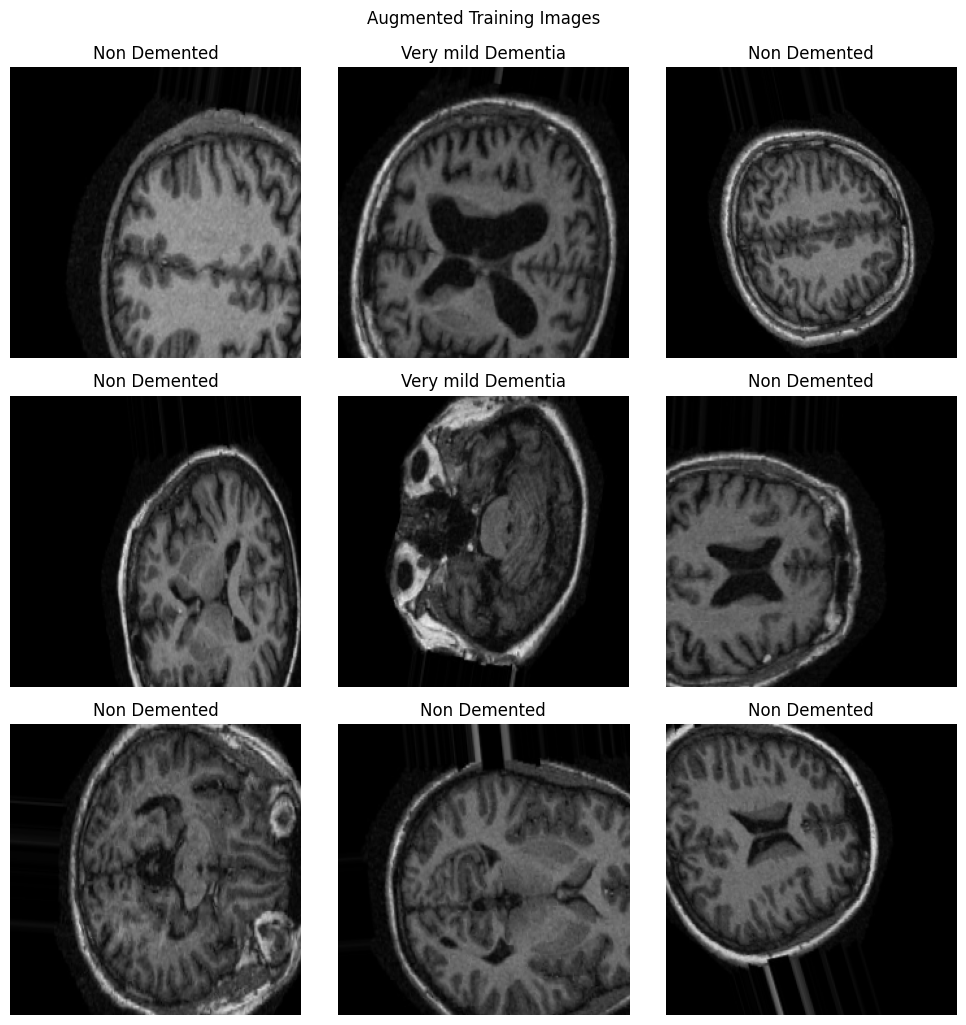

In [ ]:
# Visualize Augumented data
images, labels = next(train_generator)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Images", y=1.02)
plt.show()

<ipython-input-14-8824df654495>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="pastel")


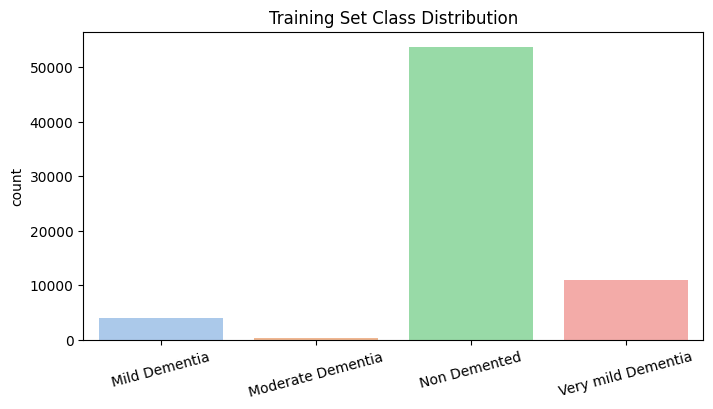

<ipython-input-14-8824df654495>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels, palette="pastel")


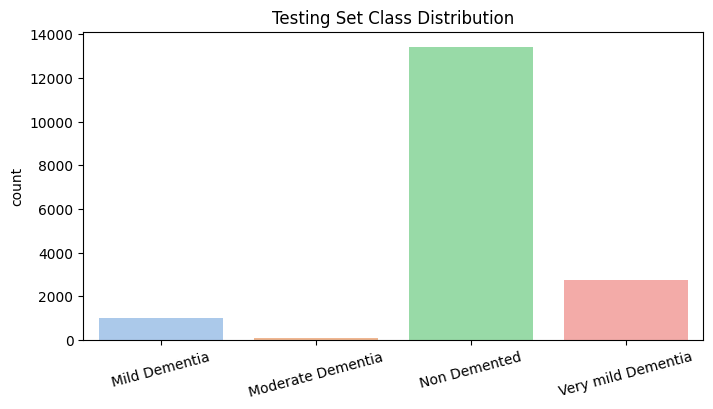

In [ ]:
# Class Distribution stats
import pandas as pd

train_labels = [idx_to_class[c] for c in train_generator.classes]
test_labels = [idx_to_class[c] for c in test_generator.classes]

plt.figure(figsize=(8, 4))
sns.countplot(x=train_labels, palette="pastel")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=test_labels, palette="pastel")
plt.title("Testing Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

In [ ]:
# Images height and width statistics
heights = image_shapes[:, 0]
widths = image_shapes[:, 1]
channels = image_shapes[:, 2]

print(f"Image Height - Mean: {np.mean(heights):.1f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
print(f"Image Width  - Mean: {np.mean(widths):.1f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Channels: {np.unique(channels)}")

Image Height - Mean: 248.0, Min: 248, Max: 248
Image Width  - Mean: 496.0, Min: 496, Max: 496
Channels: [3]


# <span style="color: red;">2-Model Building : XGBoost (eXtreme Gradient Boosting) classifier that uses VGG16 features  </span>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import shutil
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
import os
import numpy as np
import shutil
from tqdm import tqdm

# 1. Data Preparation with Subset
def create_subset(original_dir, subset_dir, class_names, samples_per_class=100):
    os.makedirs(subset_dir, exist_ok=True)

    for cls in class_names:
        cls_subset_dir = os.path.join(subset_dir, cls)
        os.makedirs(cls_subset_dir, exist_ok=True)

        src_dir = os.path.join(original_dir, cls)

        if not os.path.isdir(src_dir):
            print(f"Warning: Directory {src_dir} not found. Skipping...")
            continue

        all_files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

        if not all_files:
            print(f"Warning: No files found in {src_dir}. Skipping...")
            continue

        selected_files = np.random.choice(all_files, min(samples_per_class, len(all_files)), replace=False)

        for file in tqdm(selected_files, desc=f"Copying {cls}"):
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(cls_subset_dir, file)
            shutil.copy(src_path, dst_path)

data_dir = "/content/oasis_dataset/Data/Very mild Dementia"  # Original data directory
subset_dir = "/content/oasis_dataset/subset_data"  # Where subset will be created

class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

print("Found classes:", class_names)

create_subset(data_dir, subset_dir, class_names, samples_per_class=100)

print("Subset creation completed!")

Found classes: []
Subset creation completed!


In [ ]:
# 2. Train-Test Split for Subset
train_dir = os.path.join(subset_dir, "train")
test_dir = os.path.join(subset_dir, "test")

for cls in class_names:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def split_and_copy(source_path, class_name, train_dest, test_dest, test_ratio=0.2):
    all_files = os.listdir(source_path)
    np.random.shuffle(all_files)
    split_idx = int(len(all_files) * (1 - test_ratio))
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

for cls in class_names:
    split_and_copy(os.path.join(subset_dir, cls), cls, train_dir, test_dir)

In [ ]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    subset_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    subset_test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices

Found 160 images belonging to 4 classes.
Found 40 images belonging to 3 classes.


In [ ]:
# 3. VGG16 Feature Extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator):
    features = []
    labels = []

    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        x_batch = preprocess_input(x_batch)
        f_batch = feature_model.predict(x_batch)
        f_flat = f_batch.reshape(f_batch.shape[0], -1)
        features.append(f_flat)
        labels.append(y_batch)

    X = np.concatenate(features)
    y = np.argmax(np.concatenate(labels), axis=1)
    return X, y

X_train, y_train = extract_features(train_generator)
X_test, y_test = extract_features(test_generator)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 20%|██        | 1/5 [00:11<00:47, 11.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 40%|████      | 2/5 [00:12<00:15,  5.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████    | 3/5 [00:12<00:05,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 4/5 [00:12<00:01,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 50%|█████     | 1/2 [00:00<00:00,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


In [ ]:
print("Extracting training features...")
X_train, y_train = extract_features(train_generator)

print("Extracting testing features...")
X_test, y_test = extract_features(test_generator)

Extracting training features...


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 20%|██        | 1/5 [00:00<00:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 40%|████      | 2/5 [00:00<00:01,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 80%|████████  | 4/5 [00:01<00:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Extracting testing features...


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 50%|█████     | 1/2 [00:00<00:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


In [ ]:
# 4. Train XGBoost
clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.95


In [ ]:
# 5. Evaluation
y_pred = clf.predict(X_test)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.95


#Explainability

#Shap

In [ ]:
!pip install shap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap
from xgboost import plot_tree

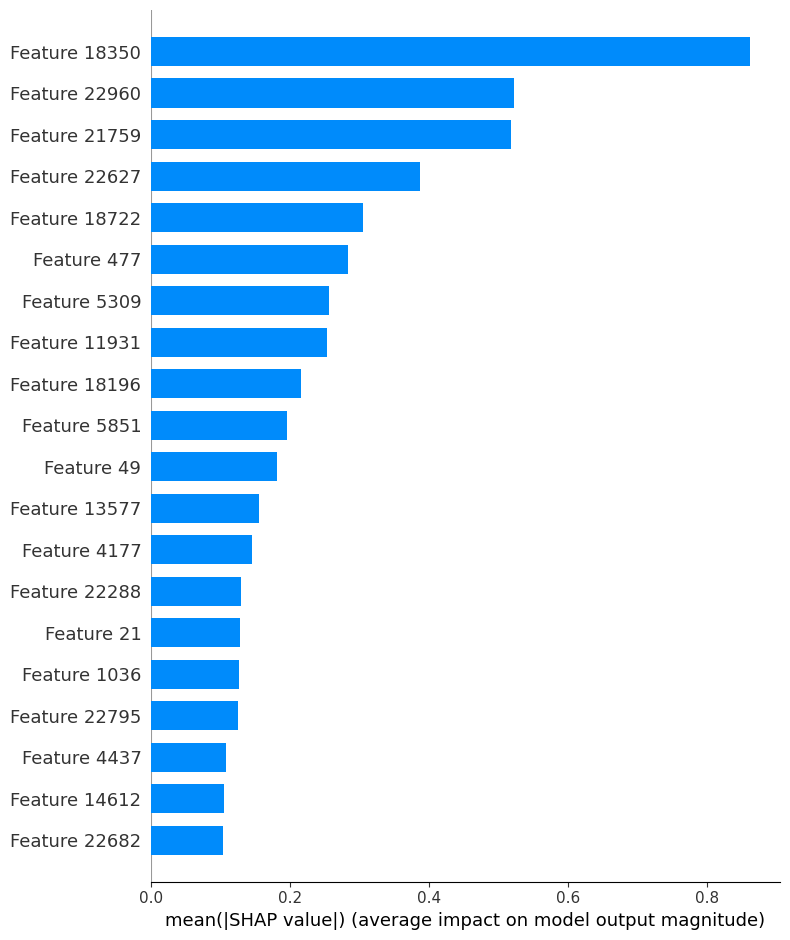

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create TreeExplainer
explainer = shap.TreeExplainer(clf)

X_sample = X_test[:10]

# SHAP values
shap_values = explainer.shap_values(X_sample)

# Global explanation
shap.summary_plot(shap_values, X_sample, plot_type="bar")

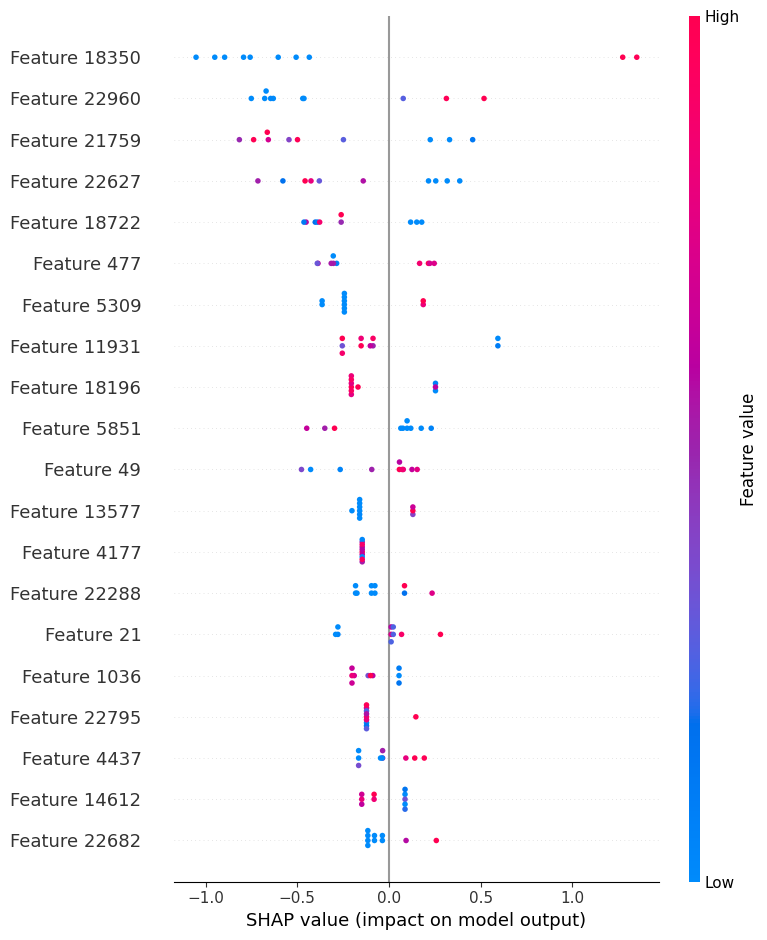

In [ ]:
# Full summary with feature distribution
shap.summary_plot(shap_values, X_sample)

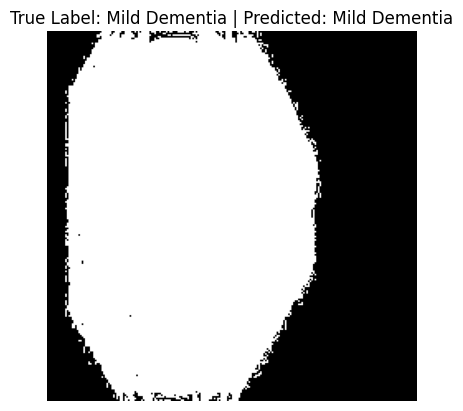

In [ ]:
original_images, _ = next(test_generator)

plt.imshow(original_images[0])
plt.title(f"True Label: {idx_to_class[y_test[0]]} | Predicted: {idx_to_class[y_pred[0]]}")
plt.axis('off')
plt.show()


#Lime

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=66aed017050c09b2b9845dd756073a8ec8050773487839cf8c87b60a6dc5a393
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Intercept 0.5292357006369216
Prediction_local [0.73681601]
Right: 0.8761422
Could not generate LIME plot: list index out of range
Showing textual explanation instead:
Error in LIME explanation: 1
This might occur if your model only predicts one class.
Try checking your model's predictions with:
print(np.unique(clf.predict(X_test)))


<Figure size 1200x800 with 0 Axes>

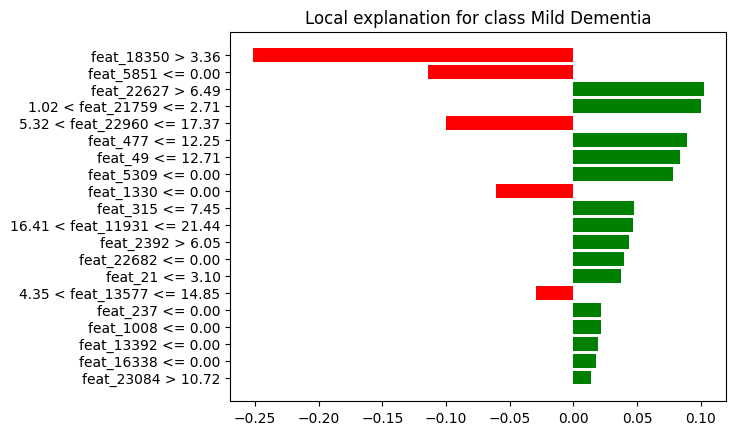

In [ ]:
try:
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=[f"feat_{i}" for i in range(X_train.shape[1])],
        class_names=list(train_generator.class_indices.keys()),
        verbose=True,
        mode='classification'
    )

    valid_samples = [i for i in range(len(X_test)) if clf.predict_proba([X_test[i]]).shape[1] > 1]
    if not valid_samples:
        raise ValueError("No valid samples found for explanation")

    sample_idx = valid_samples[0]
    exp = explainer.explain_instance(
        X_test[sample_idx],
        clf.predict_proba,
        num_features=20,
        top_labels=1
    )

    plt.figure(figsize=(12, 8))
    try:
        exp.as_pyplot_figure(label=exp.available_labels()[0])
        plt.title(f"LIME Explanation for Sample {sample_idx} (True: {class_names[y_test[sample_idx]]})")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate LIME plot: {str(e)}")
        print("Showing textual explanation instead:")
        print(exp.as_list())

    # Print textual explanation
    print("\nLIME Explanation Details:")
    print(f"Sample index: {sample_idx}")
    print(f"True class: {class_names[y_test[sample_idx]]}")
    print(f"Predicted probabilities: {clf.predict_proba([X_test[sample_idx]])[0]}")
    print("Feature contributions:")
    print(exp.as_list())

except Exception as e:
    print(f"Error in LIME explanation: {str(e)}")
    print("This might occur if your model only predicts one class.")
    print("Try checking your model's predictions with:")
    print("print(np.unique(clf.predict(X_test)))")

#Feature Importance

<Figure size 1200x800 with 0 Axes>

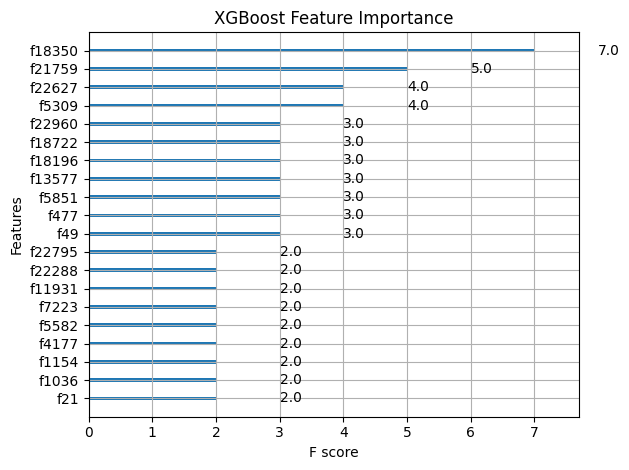

In [ ]:
from xgboost import plot_importance, plot_tree

plt.figure(figsize=(12, 8))
plot_importance(clf, max_num_features=20)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

#Decision Tree

<Figure size 7000x7000 with 0 Axes>

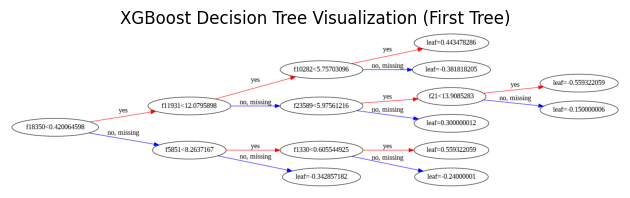

In [ ]:
plt.figure(figsize=(70, 70))
plot_tree(clf, num_trees=0, rankdir='LR')  # Visualize first tree
plt.title("XGBoost Decision Tree Visualization (First Tree)")
plt.tight_layout()
plt.show()

#Pdp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
# Get feature names
feature_names = [f'vgg16_feat_{i}' for i in range(X_train.shape[1])]

# Select top important features (using absolute SHAP values)
top_feature_indices = np.argsort(np.abs(shap_values).mean(0))[-5:][::-1]

Partial Dependence Plots (PDP)


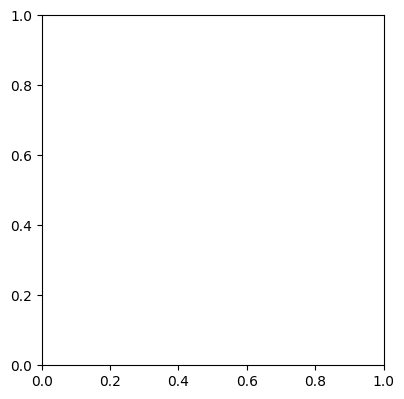

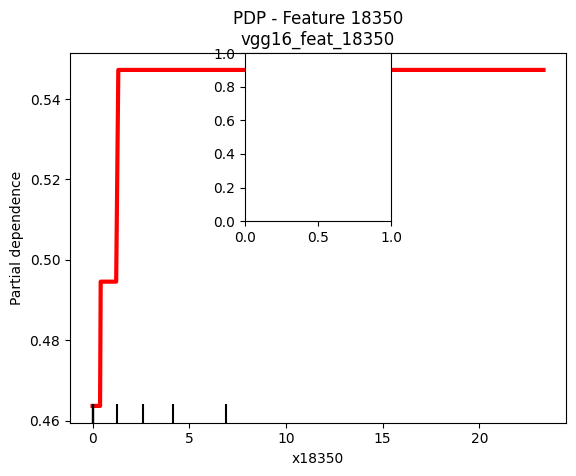

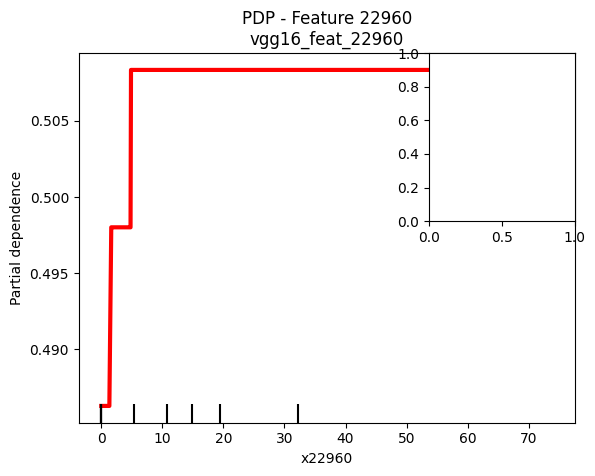

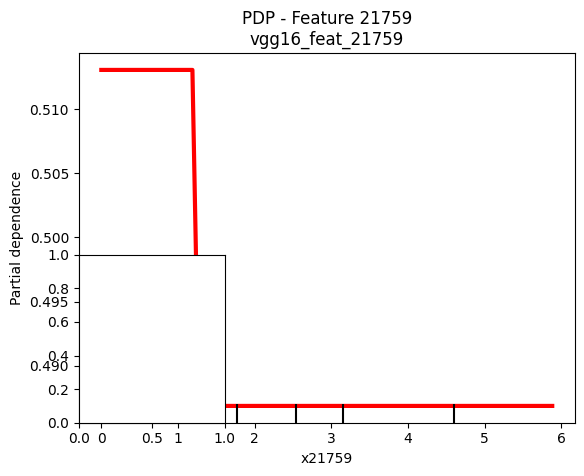

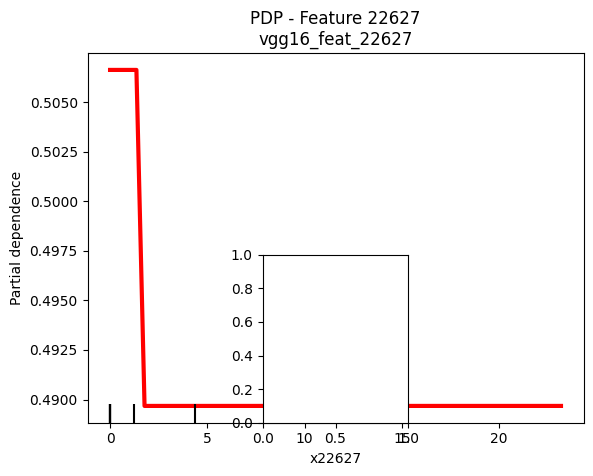

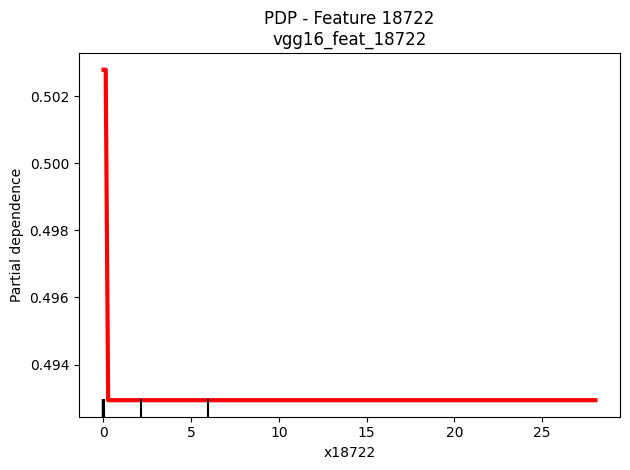

In [ ]:
#PDP Plots
print("="*50)
print("Partial Dependence Plots (PDP)")
print("="*50)
plt.figure(figsize=(15, 10))
for i, feature_idx in enumerate(top_feature_indices, 1):
    plt.subplot(2, 3, i)
    PartialDependenceDisplay.from_estimator(
        clf,
        X_train,
        features=[feature_idx],
        kind='average',
        line_kw={'color':'red', 'linewidth':3},

    )
    plt.title(f'PDP - Feature {feature_idx}\n{feature_names[feature_idx]}')
plt.tight_layout()
plt.show()

#ICE


Individual Conditional Expectation (ICE) Plots


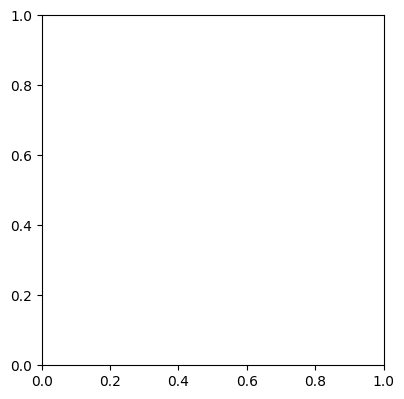

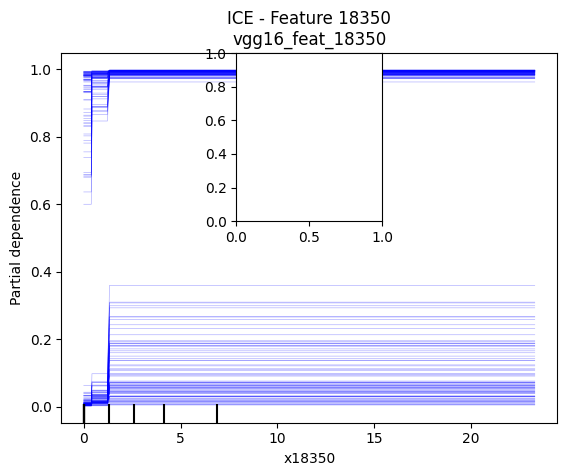

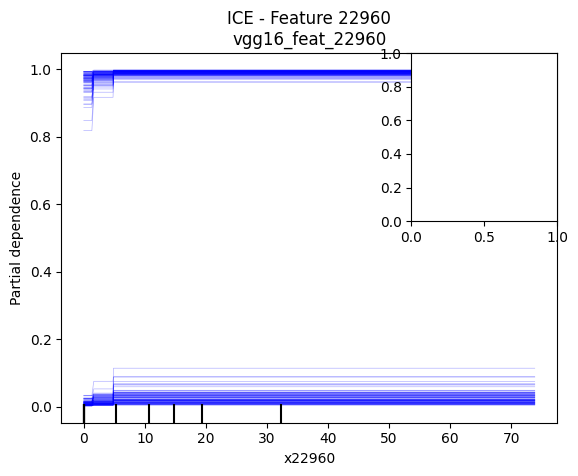

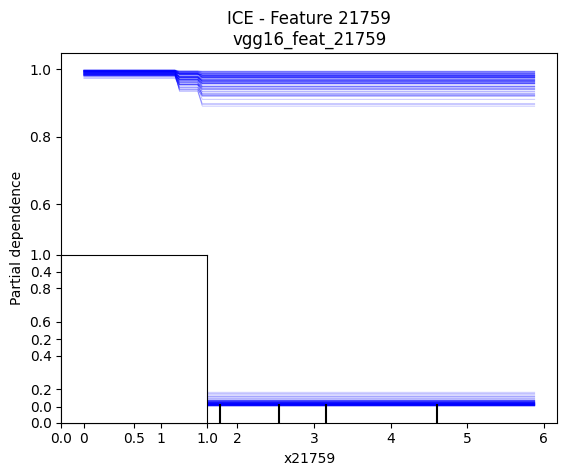

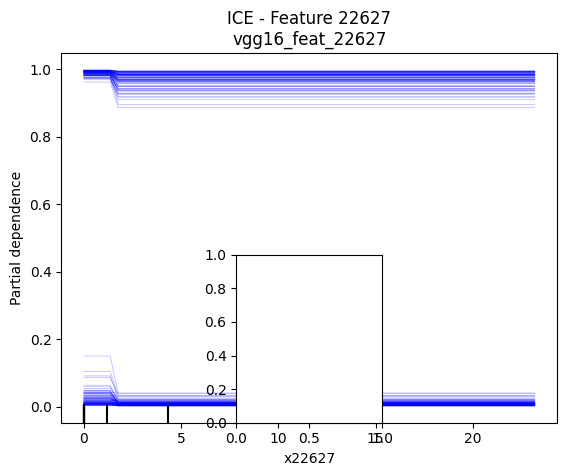

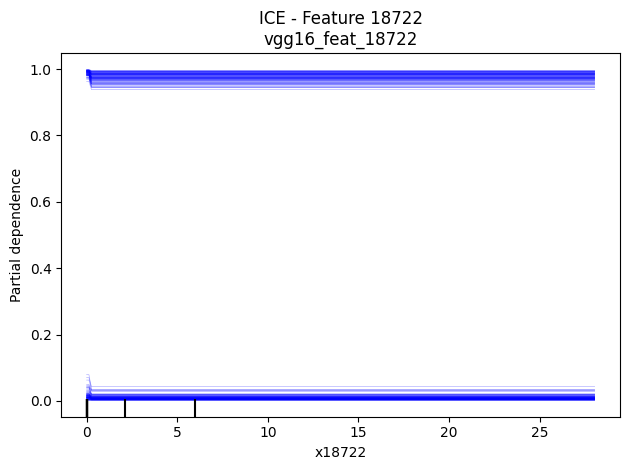

In [ ]:
print("\n" + "="*50)
print("Individual Conditional Expectation (ICE) Plots")
print("="*50)
plt.figure(figsize=(15, 10))
for i, feature_idx in enumerate(top_feature_indices, 1):
    plt.subplot(2, 3, i)
    PartialDependenceDisplay.from_estimator(
        clf,
        X_train,
        features=[feature_idx],
        kind='individual',  # ICE only
        line_kw={'color':'blue', 'alpha':0.3, 'linewidth':0.5}
    )
    plt.title(f'ICE - Feature {feature_idx}\n{feature_names[feature_idx]}')
plt.tight_layout()
plt.show()